# SPOextractor: Extracting Fact-like Structures with SpaCy

**Introduction:**

SPOextractor is a project designed for the extraction of fact-like structures, specifically subject-predicate-object (SPO) structures, from textual data. Leveraging the power of SpaCy, a leading natural language processing (NLP) library, this project aims to uncover and organize information in the form of subject-predicate-object relationships within a given text corpus.

**Objective:**

The primary goal of SPOextractor is to enhance information retrieval by identifying and extracting meaningful connections within the text. By focusing on subject-predicate-object structures, the project aims to distill factual content, making it easier to understand, analyze, and utilize the essential relationships embedded in the text.

**Key Features:**

- **SpaCy Integration:** SPOextractor relies on the capabilities of SpaCy, a powerful and efficient NLP library, to perform accurate and context-aware text processing.

- **Fact-like Structures:** The project specifically targets fact-like structures, emphasizing the extraction of subject-predicate-object relationships that represent concrete information within the text.

- **Text Corpus Analysis:** SPOextractor is designed to handle text corpora, enabling users to process large volumes of textual data and extract valuable fact-based insights.

**How It Works:**

1. **Text Processing:** The project begins by processing the input text using SpaCy, which performs tokenization, part-of-speech tagging, and dependency parsing.

2. **SPO Extraction:** Through sophisticated linguistic analysis, SPOextractor identifies and extracts subject-predicate-object structures, revealing the factual relationships present in the text.

3. **Structured Output:** The extracted information is then presented in a structured format, allowing users to easily comprehend and utilize the identified subject-predicate-object relationships.

**Applications:**

- **Information Retrieval:** SPOextractor enhances the retrieval of factual information from diverse textual sources, aiding in knowledge extraction.

- **Data Analysis:** The structured output facilitates data analysis by providing a clear representation of relationships between entities in the text.

- **Automated Processing:** The project can be integrated into automated systems, streamlining the extraction of factual content for various applications.

**Work in progress*

In [1]:
from re import sub
import collections
import spacy

nlp = spacy.load("en_core_web_sm")
nlp.add_pipe("merge_noun_chunks")

C:\Users\marko\AppData\Local\Programs\Python\Python310\lib\site-packages\spacy\util.py:910: UserWarning: [W095] Model 'en_core_web_sm' (3.0.0) was trained with spaCy v3.0.0 and may not be 100% compatible with the current version (3.7.2). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


<function spacy.pipeline.functions.merge_noun_chunks(doc: spacy.tokens.doc.Doc) -> spacy.tokens.doc.Doc>

In [2]:
def mergeTokensUponSideRelativity(tokenCompound: list, tokenComplement: list) -> list:
    """The function merges input tokens in respect to their position in a sentence"""
    mergedTokenList = tokenCompound + tokenComplement
    mergedTokenIndexDict = {}

    for tok in mergedTokenList:
        mergedTokenIndexDict[tok.i] = tok

    orderdDict = collections.OrderedDict(sorted(mergedTokenIndexDict.items()))

    return list(orderdDict.values())

def demlimiter(seq: list) -> dict:
    """The function creates dict object using delimiter as key and its set as value"""
    result_dict = {}
    l = []
    for token in seq:
        # the hypothesis is that object sequence ends with object itself
        if token.dep_ in ["pobj", "dobj", "obj", "conj"]:
            # compile obj and its complementation then add to dict, obj as key
            l.append(token)
            result_dict[token.text] = ' '.join([token.text for token in l])
            # empty the list
            l = []
        else:
            # fill the list with object complementation
            l.append(token)
    return result_dict

def getVerbConj(verb) -> tuple:
    """The function gets verbs' conjuctions"""
    # Condition - verb has conjuctions
    allConjCompl = []
    allConjs = []
    for child in verb.children:
        if child.dep_ == "conj":
            allConjs.append(child)
            conjCompl = getVerbComplementation(child)
            conjComplStr = [token.text for token in conjCompl]

            allConjCompl.append(' '.join(conjComplStr))

            c, cc = getVerbConj(child) # recursion
            for conj in cc:
                allConjCompl.append(conj)
            for co in c:
                allConjs.append(co)

    return allConjs, allConjCompl

def getVerbComplementation(verb) -> list:
    """The function extracts verb and all other words that complement it"""
    verbComplement = [verb]
    for verbChild in verb.children:
        if verbChild.dep_ in ("neg", "aux", "auxpass", "advmod", "attr", "prt"):
            verbComplement = mergeTokensUponSideRelativity([verbChild], verbComplement)
        elif verbChild.dep_ == "acomp" and verbChild.pos_ in ("VERB", "AUX", "ADJ", "NOUN"):
            verbAcomp = getVerbComplementation(verbChild) # recursion
            verbComplement = mergeTokensUponSideRelativity(verbAcomp, verbComplement)
        elif verbChild.dep_ == "xcomp" and verbChild.pos_ in ("VERB", "AUX", "ADJ", "NOUN"):
            verbXcomp = getVerbComplementation(verbChild) # recursion
            verbComplement = mergeTokensUponSideRelativity(verbXcomp, verbComplement)

    return verbComplement

def getVerbObject(verb) -> list:
    """The function gets the objects to which the verb refers"""

    verbObjects = []
    for verbChild in verb.children:
        # if verbs' direct child is object
        # TODO: conj should have the same complementation as obj?
        if verbChild.dep_ in ("pobj", "dobj", "obj", "conj") and verbChild.pos_ != "VERB": # because verb can't be an object
            objectComp = getVerbObject(verbChild) # recursion
            objectCompWithPrep = objectComp + [verbChild]
            verbObjects = mergeTokensUponSideRelativity(objectCompWithPrep, verbObjects)

        elif verbChild.dep_ in ("prep", "pcomp", "agent", "acl"): ## acl ????
            objectComp = getVerbObject(verbChild) # recursion
            objectCompWithPrep = objectComp + [verbChild]
            verbObjects = mergeTokensUponSideRelativity(objectCompWithPrep, verbObjects)

        elif verb.pos_ == "AUX" and verbChild.dep_ == "attr":
            objectComp = getVerbObject(verbChild)  # recursion
            verbObjects = mergeTokensUponSideRelativity(objectComp, verbObjects)

    return verbObjects

def getSPO(subject) -> dict:
    """The function gets relations subject-predicate-object upon subject as input"""
    spo = {}

    subjectList = [token.lemma_.lower() for token in list(subject.subtree)]
    subjectComplement = ' '.join(subjectList)

    verbComplementList = [token.text for token in getVerbComplementation(subject.head) if subject.head.pos_ in ["VERB", "AUX"]]
    predicate = ' '.join(verbComplementList)

    res = demlimiter(getVerbObject(subject.head))
    objects = list(res.values())
    spo[predicate] = (subjectComplement, objects)

    conj, conjCompl = getVerbConj(subject.head)
    conjDic = dict(zip(conj, conjCompl))

    for c, cpredicate in conjDic.items():
        spo[cpredicate] = (subjectComplement, getVerbObject(c))

    return spo

def getSPODependecy(text) -> list:
    """The function gets all SPO relations from the input text"""
    SPOlist = []
    # TODO: first conduct coreference resolution on whole doc
    for sent in text.sents:
        for token in sent:
            # token is subject
            if token.dep_ == "nsubj" or token.dep_ == "nsubjpass":
                SPOlist.append(getSPO(token))

    return SPOlist



In [26]:
text = "Cognitive science is the study of the human mind and brain, focusing on how the mind represents and manipulates knowledge and how mental representations and processes are realized in the brain. Cognitive scientists study intelligence and behavior, with a focus on how nervous systems represent, process, and transform information."
doc = nlp(text)

listOfFacts = getSPODependecy(doc)

s = []
p = []
o = []
import pandas as pd
for fact in listOfFacts:
    for k, v in fact.items():
        for obj in v[1]:
            s.append(v[0])
            p.append(k)
            o.append(obj)

# table Facts
df = pd.DataFrame({"subject":s, "predicate":p, "object":o})
df

,subject,predicate,object
0,cognitive science,is the study,of the human mind
1,cognitive science,is the study,brain
2,the mind,manipulates,knowledge
3,the mind,are realized,in
4,the mind,are realized,the brain
5,how mental representation and process,are realized,in the brain
6,cognitive scientist,study,intelligence
7,cognitive scientist,study,behavior
8,cognitive scientist,study,with a focus
9,cognitive scientist,study,on represent process


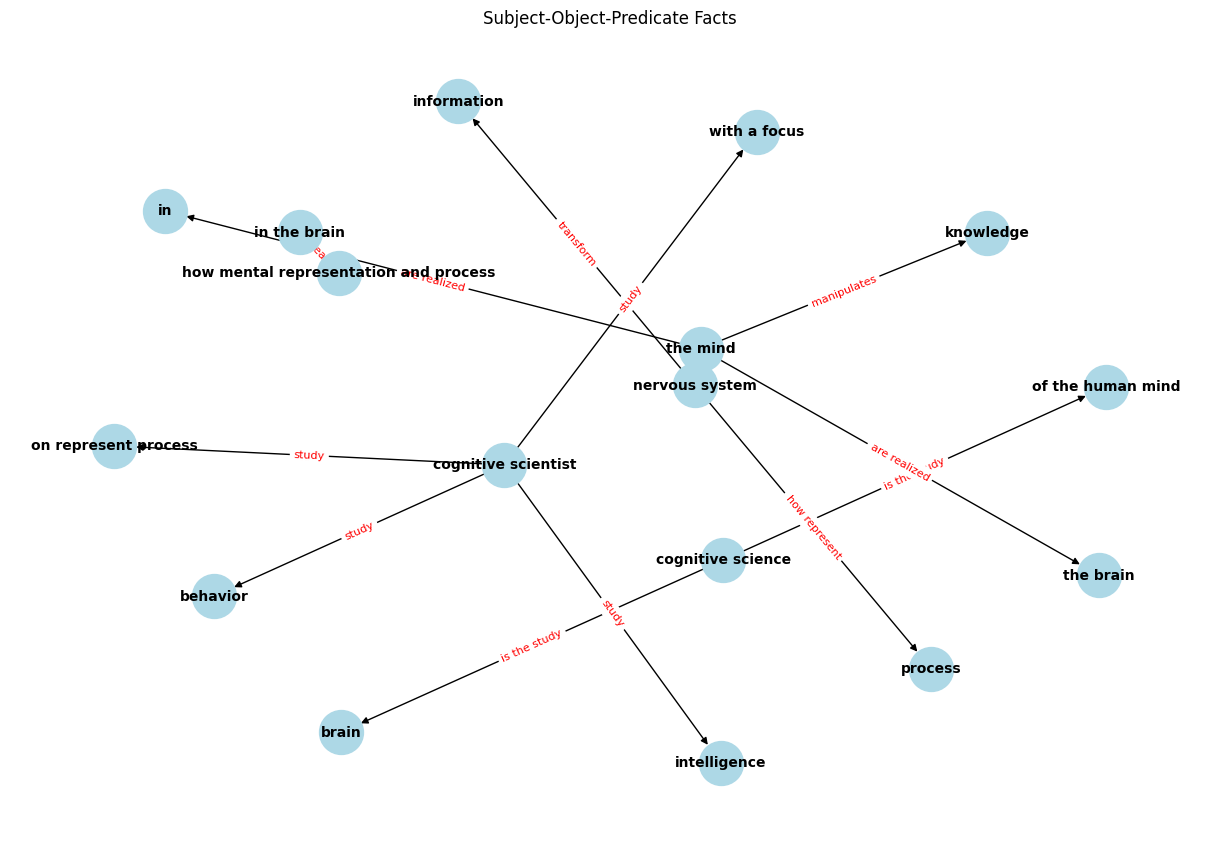

In [27]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt


# Create a directed graph
G = nx.DiGraph()

# Add edges representing the facts
for index, row in df.iterrows():
    G.add_edge(row['subject'], row['object'], label=row['predicate'])

# Draw the graph
pos = nx.spring_layout(G, seed=42)
plt.figure(figsize=(12, 8))  # Adjust the figure size here
nx.draw(G, pos, with_labels=True, node_size=1000, node_color="lightblue", font_size=10, font_weight="bold")
edge_labels = nx.get_edge_attributes(G, 'label')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red', font_size=8)

plt.title("Subject-Object-Predicate Facts")
plt.show()